In [1]:
from typing import List
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from dataclasses import asdict
import pandas as pd

import matplotlib.pyplot as plt


import torch

from chinese_checkers.simulation import GameSimulation, S3SimulationCatalog 
from chinese_checkers.model.BootstrapModel import BootstrapModel
from chinese_checkers.experience import ExperienceData, S3ExperienceCatalog, ExperienceMetadata

from chinese_checkers.cnn import CnnEncoderExperience, CnnEncoderState, CnnEncoderMove, DqlCnnAgent, DqlCnnModel

print("CUDA Available:", torch.cuda.is_available())

def print_err(error_values):
    epochs = [entry['epoch'] for entry in error_values]
    test_errors = [entry['test_error'] for entry in error_values]
    validation_errors = [entry['validation_error'] for entry in error_values]
    validation_errors_discounted = [entry['validation_error_discounted_returns'] for entry in error_values]
    
    # Plotting the lines with different styles
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, test_errors, label='Test Error', linestyle=':', marker='o')
    plt.plot(epochs, validation_errors, label='Validation Error', linestyle='--')
    plt.plot(epochs, validation_errors_discounted, label='Validation Error (Discounted Returns)', linestyle='-')
    
    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Error Value')
    plt.title('Error Values over Epochs')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'training-error-{model_version}.png')
    plt.show()

CUDA Available: True


In [2]:
generator_name="CnnExperienceEncoder-v006"

catalog = S3ExperienceCatalog()
dataset_metadata: List[ExperienceMetadata] = catalog.list_datasets()
pd.DataFrame([asdict(m) for m in dataset_metadata if m.generator_name == generator_name])

,player_count,board_size,max_game_length,winning_player,name,version,generator_name,current_player
0,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v006,0
1,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v006,3
2,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v006,0
3,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v006,3
4,2,4,1000,0,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v006,0
5,2,4,1000,0,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v006,3
6,2,4,1000,3,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v006,0
7,2,4,1000,3,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v006,3
8,2,4,1000,0,bootstrap-simulation-p0d05-p0d25,v0.0.1,CnnExperienceEncoder-v006,0
9,2,4,1000,0,bootstrap-simulation-p0d05-p0d25,v0.0.1,CnnExperienceEncoder-v006,3


In [3]:
player_count = 2
current_player = "0"
board_size = 4

In [4]:
# Initialize tqdm with detailed postfix for metadata info
experiences: List[ExperienceData] = []
progress_bar = tqdm(dataset_metadata, desc="Loading datasets")

for metadata in progress_bar:
    # Dynamically set postfix with metadata name and generator name
    progress_bar.set_postfix(name=metadata.name, generator=metadata.generator_name, total=len(experiences))
    
    if (
        metadata.player_count == str(player_count)
        and metadata.current_player == current_player
        and metadata.generator_name == generator_name
        and metadata.board_size == str(board_size)
    ):
        experiences.extend(catalog.load_random_batch(metadata, 50))

print(f"Found {len(experiences)} datasets for player_count: {player_count}, and current_player: {current_player}.")

Loading datasets: 100%|██████████| 72/72 [16:04<00:00, 13.39s/it, generator=CnnExperienceEncoder-v005, name=bootstrap-0d01-vs-dql-v004, total=217703]       

Found 217703 datasets for player_count: 2, and current_player: 0.


In [5]:
from collections import defaultdict

def limit_duplicates(experiences, max_count):
    # Dictionary to count occurrences
    occurrence_count = defaultdict(int)
    
    # List to hold filtered experiences
    filtered_experiences = []
    
    for experience in experiences:
        # Only add experience if it hasn't reached the max_count
        if occurrence_count[experience.action_hash()] < max_count:
            filtered_experiences.append(experience)
            occurrence_count[experience.action_hash()] += 1
            
    return filtered_experiences
max_count = 1
filtered_experiences = limit_duplicates(experiences, max_count)
print(f"Found {len(filtered_experiences)} experiences after removing duplicates with limit {max_count}")

Found 217703 experiences after removing duplicates with limit 1


In [6]:
len(limit_duplicates([experiences[0], experiences[0]], 1))

1

In [7]:
p0_win_count = len([e for e in experiences if e.metadata.winning_player =="0"])
p3_win_count = len([e for e in experiences if e.metadata.winning_player =="3"])
no_win_count = len([e for e in experiences if not e.metadata.winning_player in ["0", "3"]])

print(f"p0_win_count {p0_win_count}, p3_win_count {p3_win_count}, no_win_count {no_win_count}")

p0_win_count 107132, p3_win_count 110571, no_win_count 0


In [9]:
sim_catalog = S3SimulationCatalog()
sim_metadata: List[GameSimulation] = [
    m 
    for m in sim_catalog.list_datasets()
    if m.winning_player in ["0", "3"]
        and m.name == "bootstrap-simulation-short"
]
pd.DataFrame([asdict(m) for m in sim_metadata])

,player_count,board_size,max_game_length,winning_player,name,version
0,2,4,200,0,bootstrap-simulation-short,v0.0.1
1,2,4,200,3,bootstrap-simulation-short,v0.0.1


In [10]:
simulations: List[GameSimulation] = []
progress_bar = tqdm(sim_metadata, desc="Loading datasets")

for metadata in progress_bar:
    # Dynamically set postfix with metadata name and generator name
    progress_bar.set_postfix(name=metadata.name, total=len(simulations))
    simulations.extend(sim_catalog.load_dataset(metadata))

print(f"Found {len(simulations)} datasets for player_count: {player_count}, and current_player: {current_player}.")

Loading datasets: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it, name=bootstrap-simulation-short, total=177]

Found 359 datasets for player_count: 2, and current_player: 0.


In [11]:
state_encoder = CnnEncoderState(board_size)
move_encoder = CnnEncoderMove(board_size)
cnn_encoder = CnnEncoderExperience("v006")
model_version = "v008-200batch"
# Define model parameters
gamma = 0.99
lr = 0.0001
batch_size = 2**7
model_save_path = f"dql_cnn_model_{model_version}.pth"

Training Progress:   0%|          | 0/20 [09:54<?, ?it/s, Test Error=77594.9183, Validation Error=77587.5442, Validation Error (Discounted)=3519186723.8200]

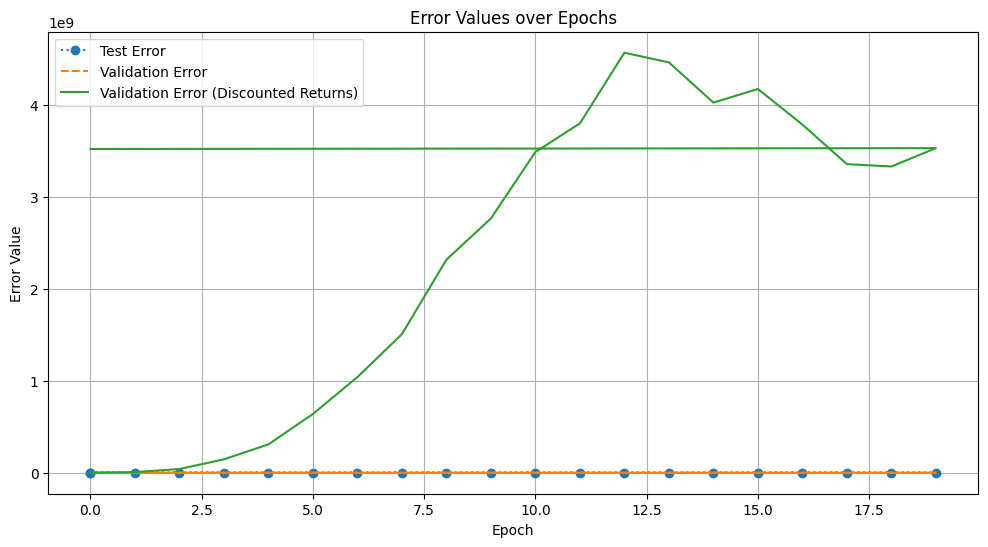

Training Progress:   5%|▌         | 1/20 [19:50<3:08:27, 595.12s/it, Test Error=78060.8523, Validation Error=78053.6628, Validation Error (Discounted)=3569766417.0912]

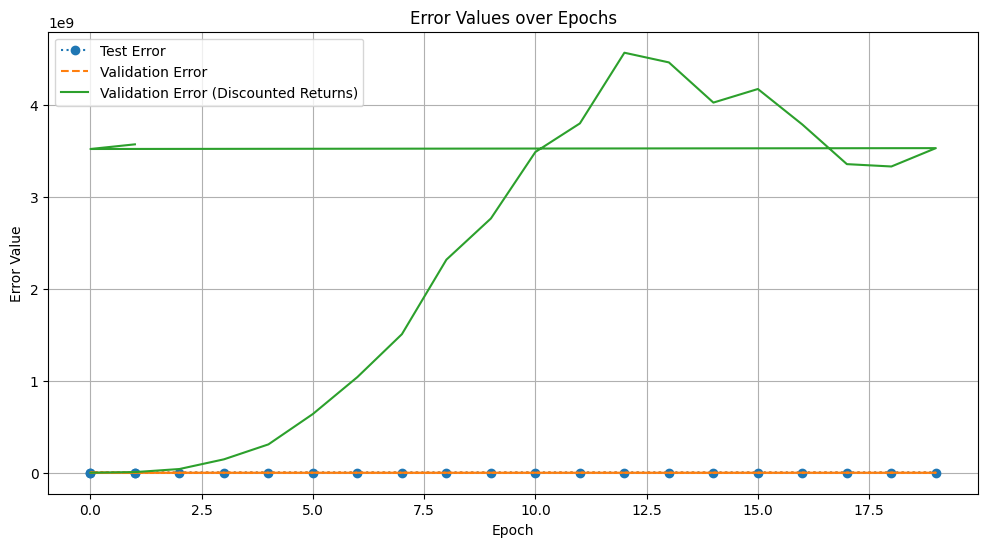

Training Progress:  10%|█         | 2/20 [29:44<2:58:38, 595.50s/it, Test Error=75450.1129, Validation Error=75443.6172, Validation Error (Discounted)=3307358548.9095]

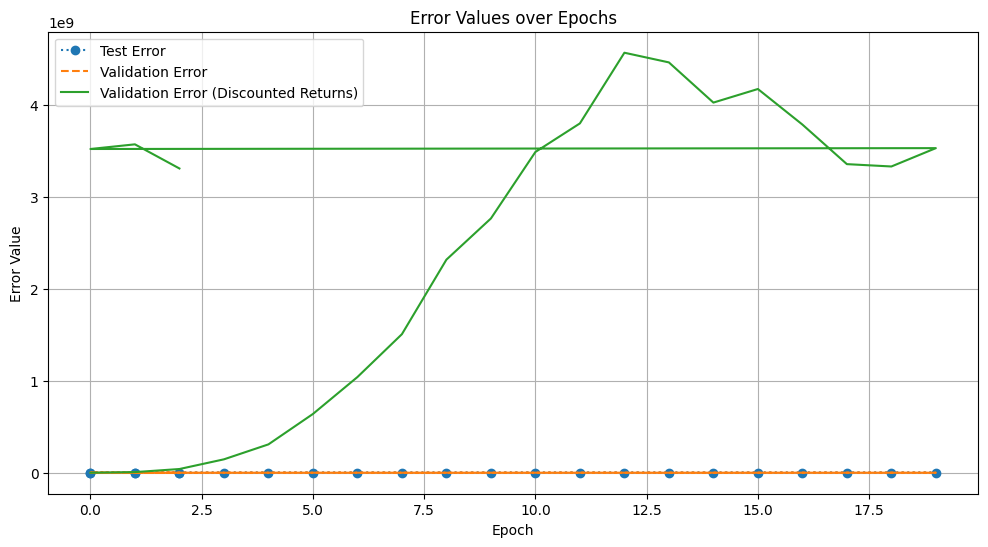

Training Progress:  15%|█▌        | 3/20 [39:38<2:48:29, 594.70s/it, Test Error=77252.3924, Validation Error=77245.7365, Validation Error (Discounted)=3490337786.0958]

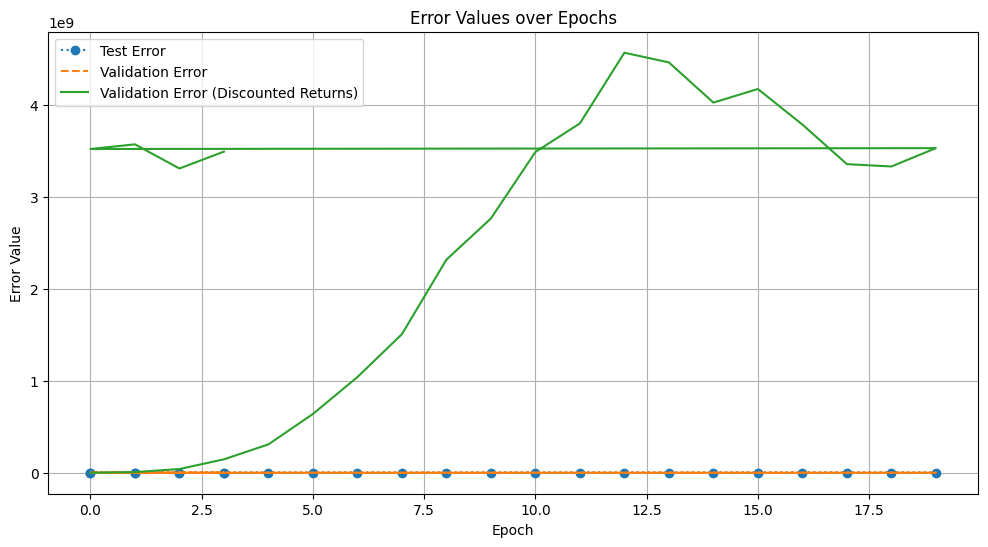

Training Progress:  20%|██        | 4/20 [49:34<2:38:34, 594.64s/it, Test Error=80548.5073, Validation Error=80541.6521, Validation Error (Discounted)=3839663855.8160]

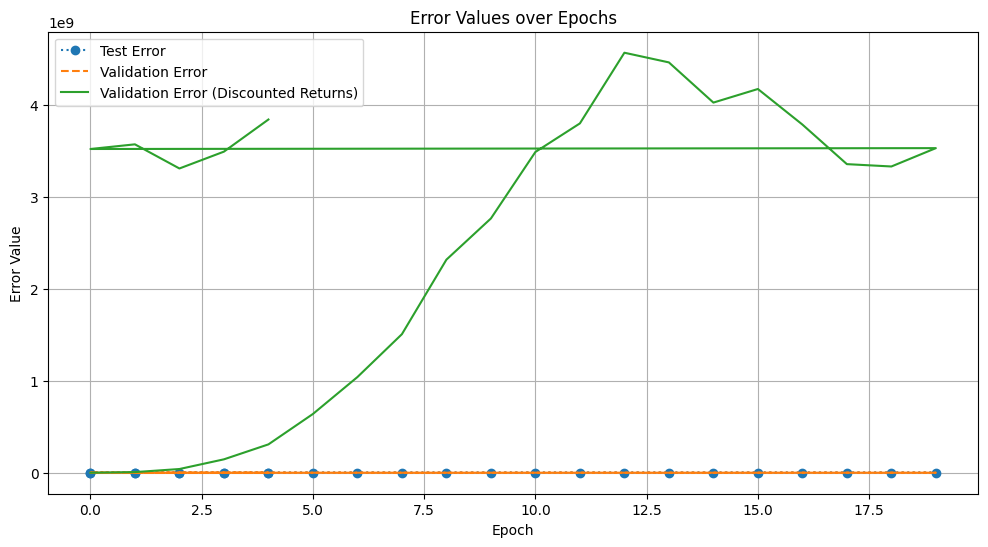

Training Progress:  25%|██▌       | 5/20 [59:28<2:28:45, 595.06s/it, Test Error=83554.8491, Validation Error=83548.1813, Validation Error (Discounted)=4176004649.0349]

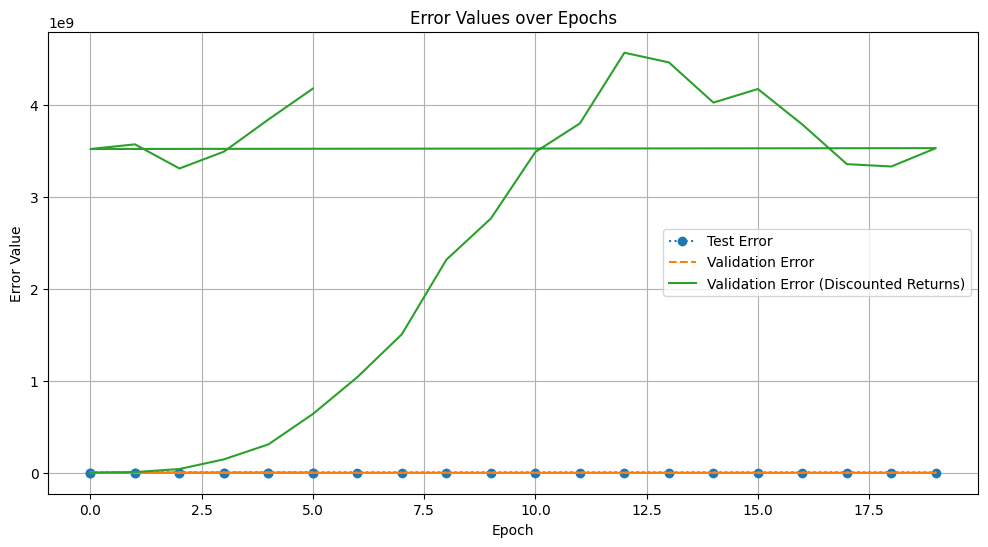

Training Progress:  30%|███       | 6/20 [1:09:23<2:18:45, 594.67s/it, Test Error=86628.5323, Validation Error=86621.5478, Validation Error (Discounted)=4532943390.0365]

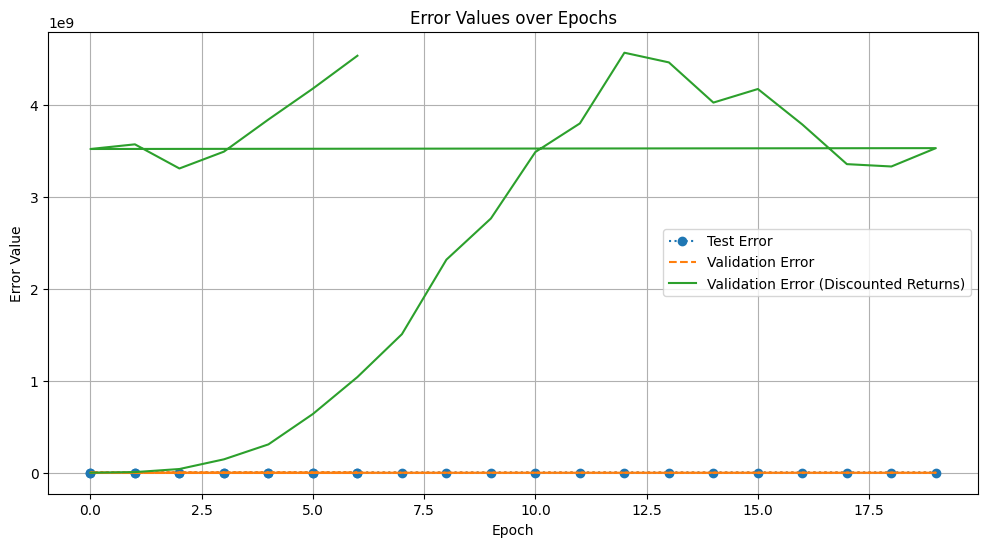

Training Progress:  35%|███▌      | 7/20 [1:19:19<2:08:52, 594.77s/it, Test Error=94129.7372, Validation Error=94122.2057, Validation Error (Discounted)=5468356970.2997]

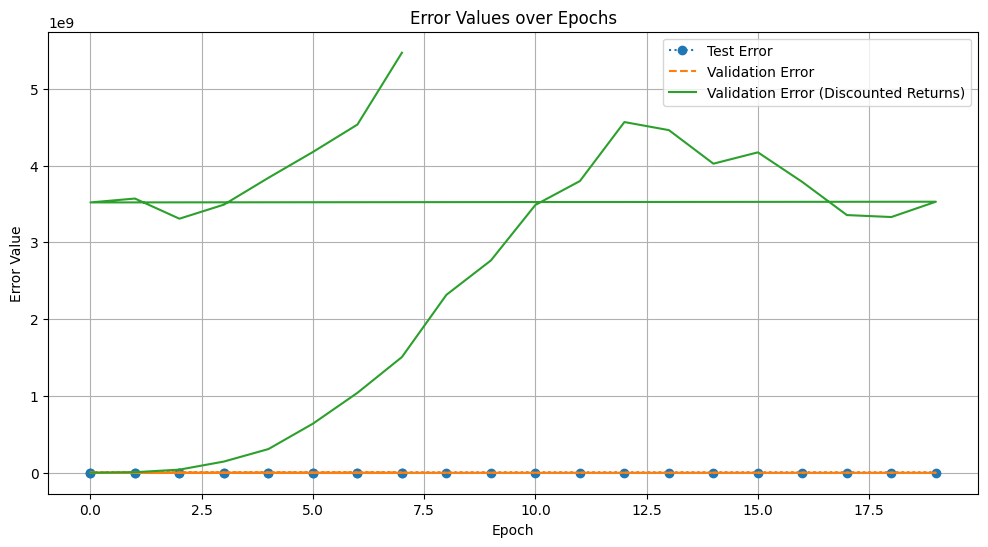

Training Progress:  40%|████      | 8/20 [1:29:13<1:59:00, 595.01s/it, Test Error=96111.5640, Validation Error=96104.2136, Validation Error (Discounted)=5734495296.8642]

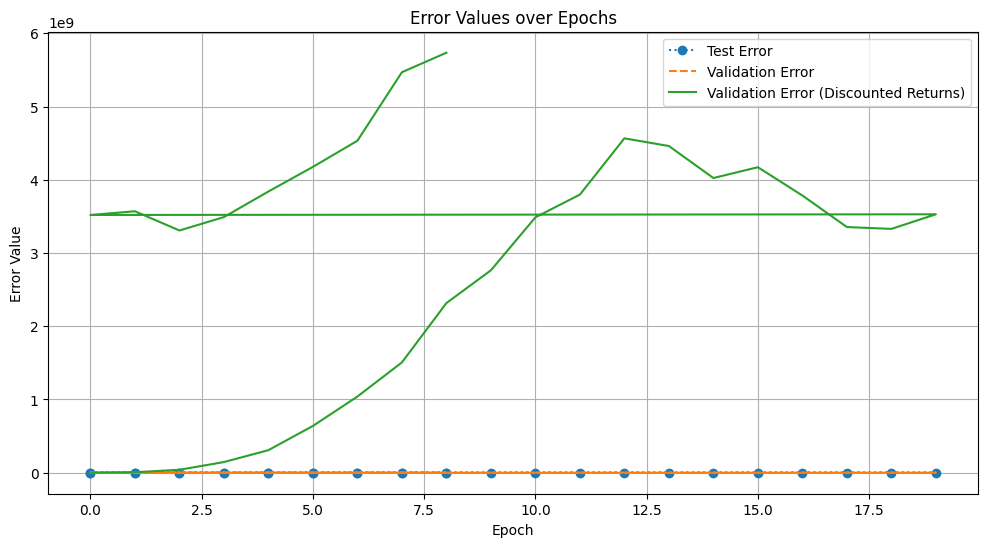

Training Progress:  45%|████▌     | 9/20 [1:39:08<1:49:04, 594.93s/it, Test Error=93130.7861, Validation Error=93124.0702, Validation Error (Discounted)=5346243888.3603]

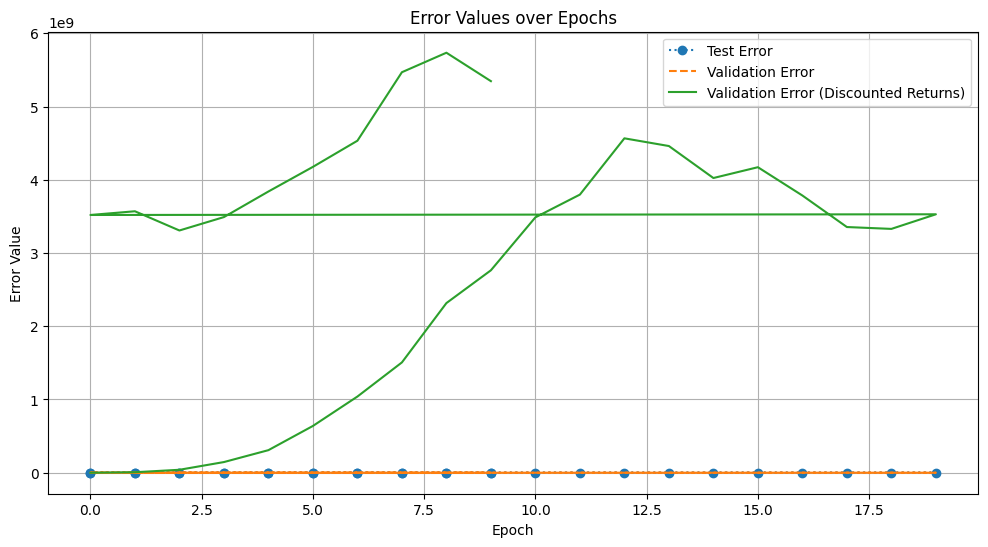

Training Progress:  50%|█████     | 10/20 [1:49:05<1:39:09, 594.96s/it, Test Error=98552.1976, Validation Error=98545.0107, Validation Error (Discounted)=6070690191.9893]

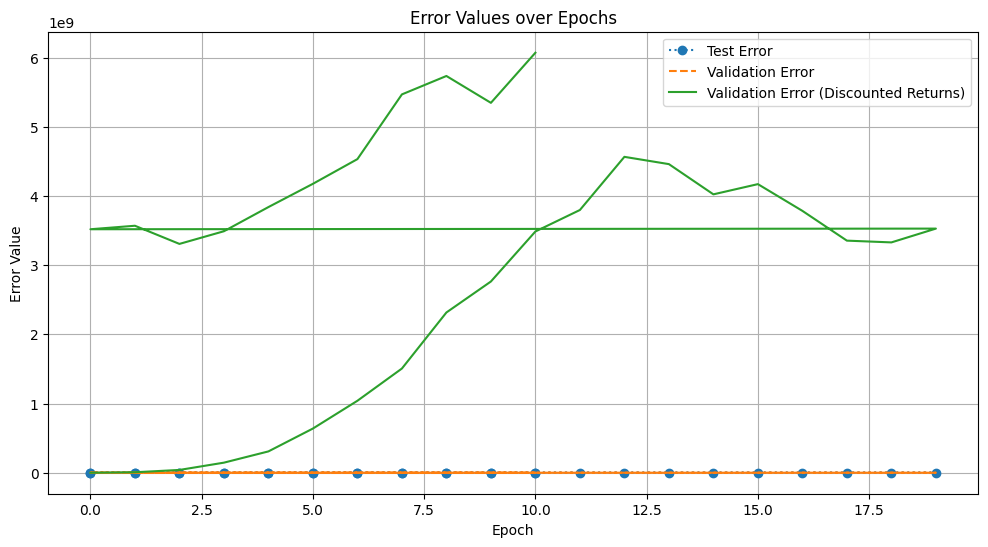

Training Progress:  55%|█████▌    | 11/20 [1:59:00<1:29:19, 595.55s/it, Test Error=106612.0412, Validation Error=106604.4758, Validation Error (Discounted)=7241814770.9102]

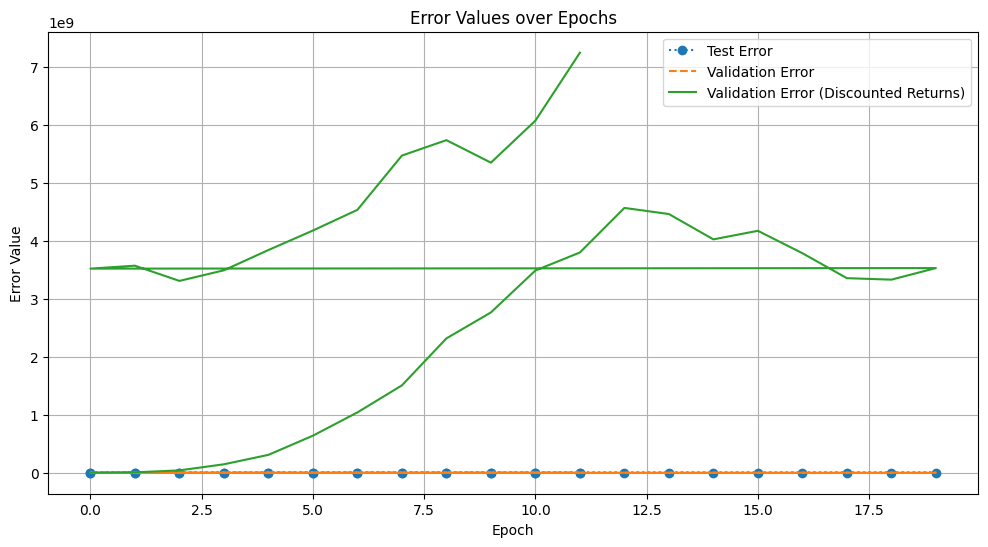

Training Progress:  60%|██████    | 12/20 [2:08:55<1:19:21, 595.18s/it, Test Error=113457.4555, Validation Error=113449.1216, Validation Error (Discounted)=8319331933.0934]

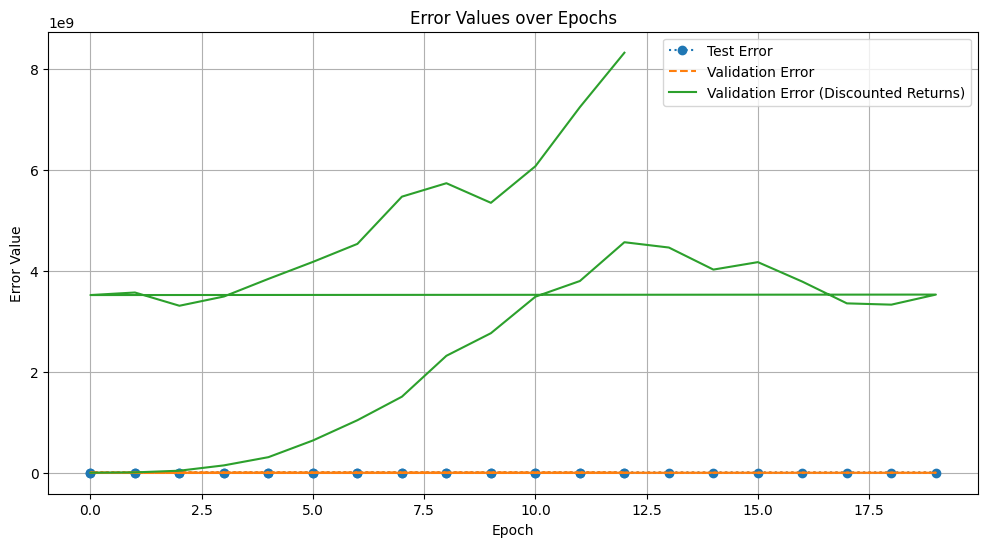

Training Progress:  65%|██████▌   | 13/20 [2:18:50<1:09:26, 595.21s/it, Test Error=116881.1458, Validation Error=116872.9057, Validation Error (Discounted)=8895536039.1280]

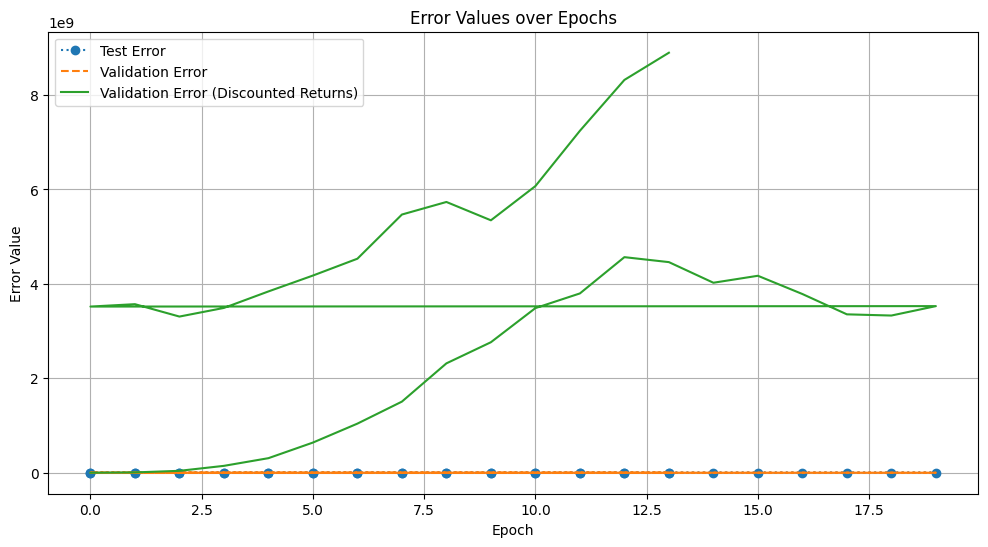

Training Progress:  70%|███████   | 14/20 [2:28:44<59:31, 595.27s/it, Test Error=116292.1559, Validation Error=116284.0972, Validation Error (Discounted)=8804187208.5070]  

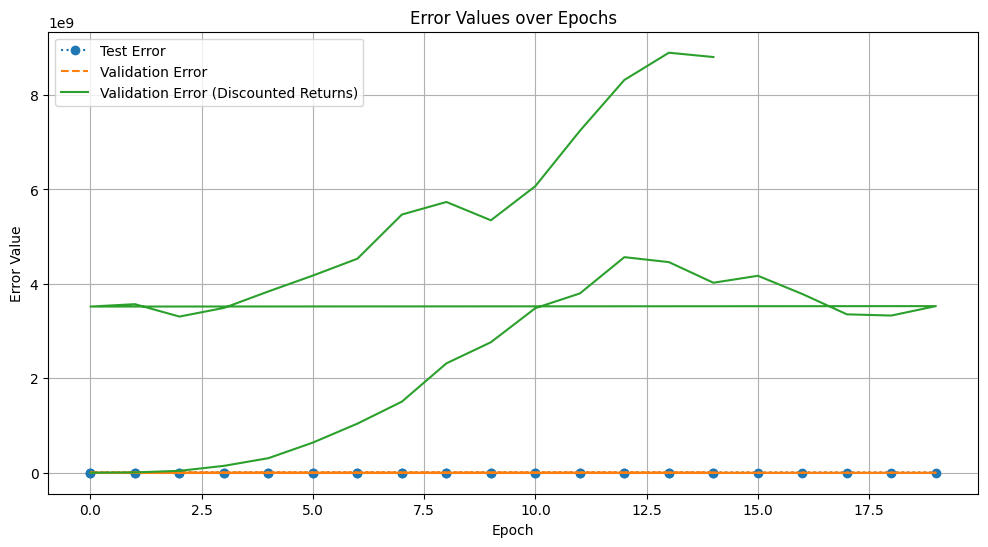

Training Progress:  75%|███████▌  | 15/20 [2:38:39<49:34, 594.83s/it, Test Error=130957.6105, Validation Error=130947.9109, Validation Error (Discounted)=11446182425.3260]

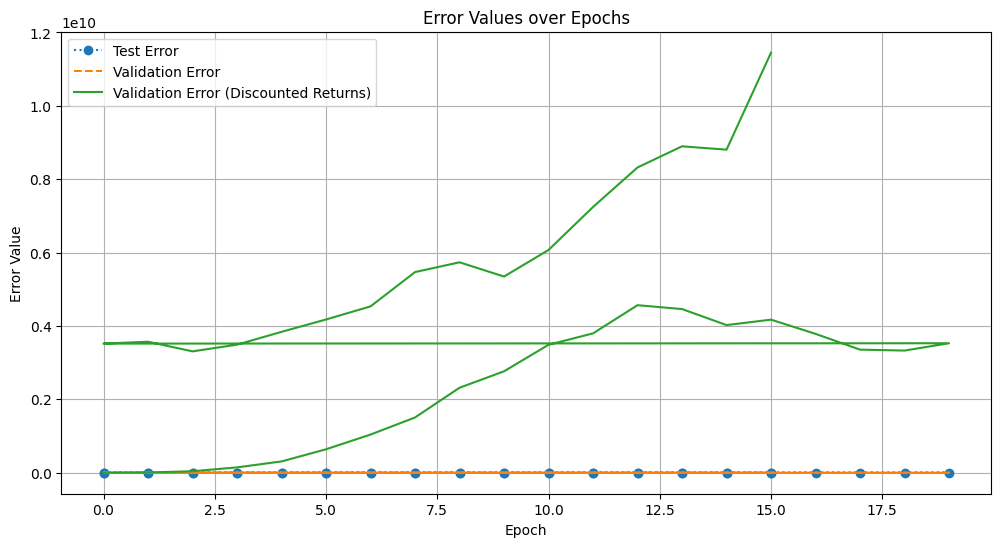

Training Progress:  80%|████████  | 16/20 [2:48:34<39:39, 594.87s/it, Test Error=140506.2575, Validation Error=140496.0861, Validation Error (Discounted)=13370295369.8643]

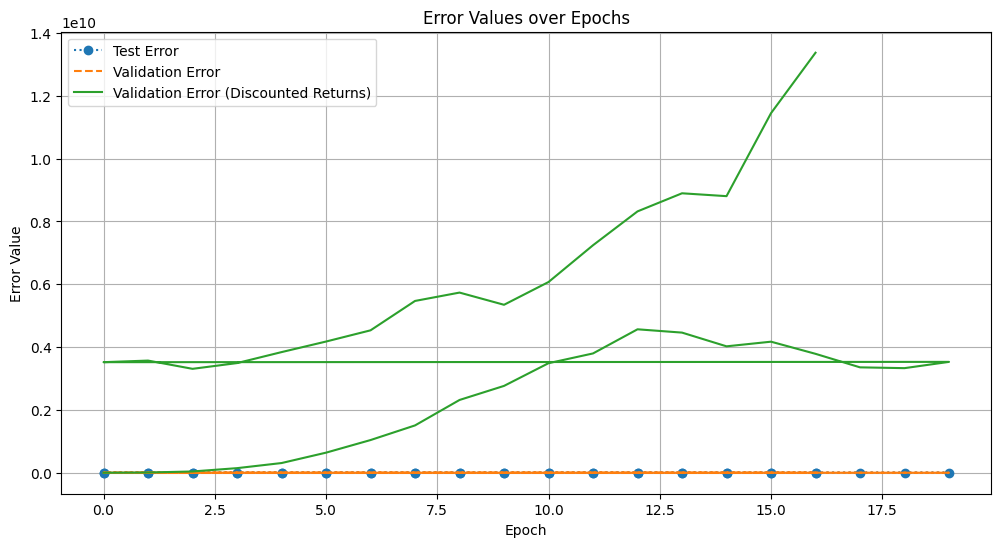

Training Progress:  85%|████████▌ | 17/20 [2:58:27<29:44, 594.93s/it, Test Error=161860.4872, Validation Error=161848.2479, Validation Error (Discounted)=18235870073.3172]

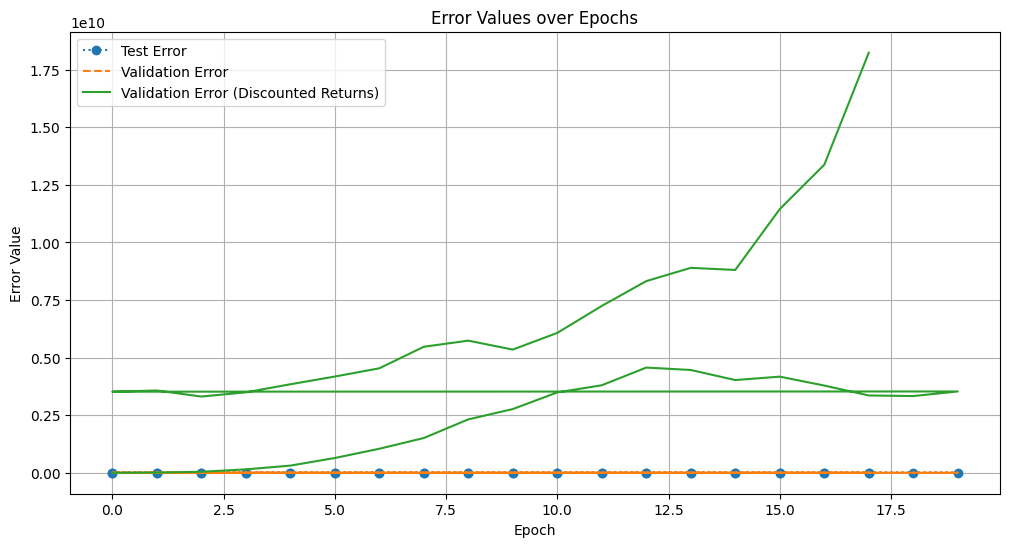

Training Progress:  90%|█████████ | 18/20 [3:08:44<19:48, 594.43s/it, Test Error=177025.2504, Validation Error=177012.5200, Validation Error (Discounted)=22179673027.0824]

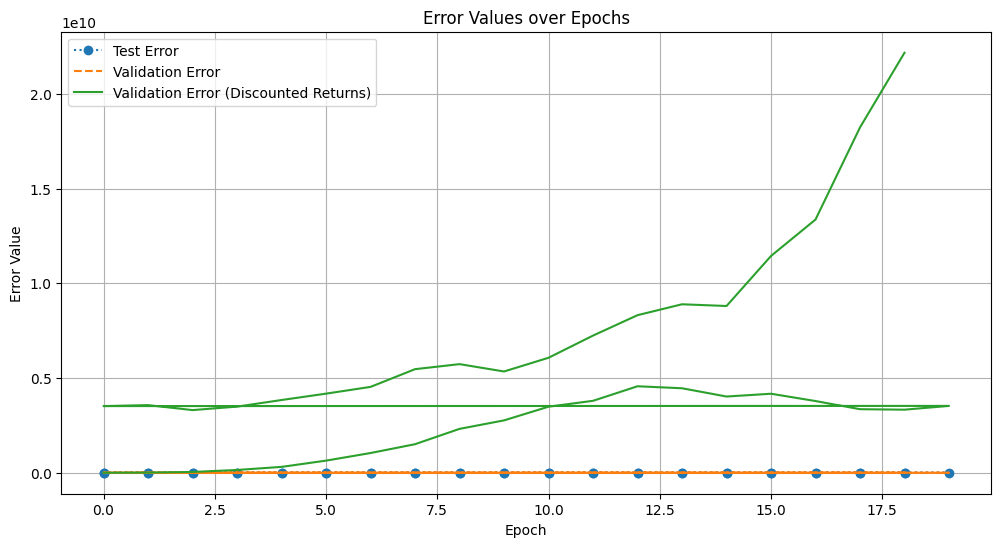

Training Progress:  95%|█████████▌| 19/20 [3:18:51<10:00, 600.97s/it, Test Error=195553.4932, Validation Error=195538.8847, Validation Error (Discounted)=27537730979.6431]

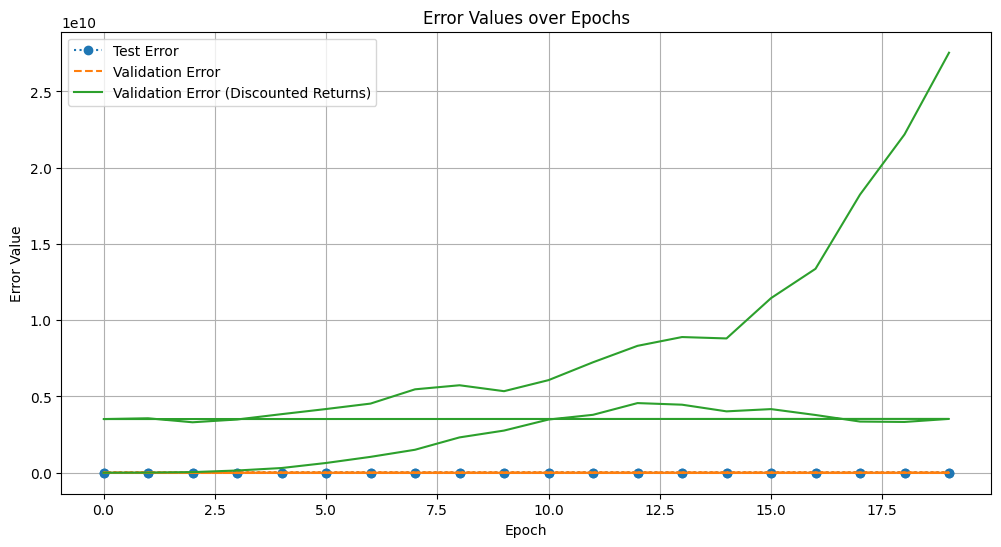

Training Progress: 100%|██████████| 20/20 [3:18:51<00:00, 596.58s/it, Test Error=195553.4932, Validation Error=195538.8847, Validation Error (Discounted)=27537730979.6431]

Model and components saved to dql_cnn_model_v008-200batch.pth


In [15]:
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets (80/20 split)
# experience_datas = [e.data for e in experiences]
# train_experiences, test_experiences = train_test_split(experience_datas, test_size=0.2, random_state=42)

# # Initialize the agent
# agent = DqlCnnAgent(
#     state_encoder=state_encoder,
#     move_encoder=move_encoder,
#     experience_encoder = cnn_encoder,
#     gamma=gamma,
#     lr=lr,
#     batch_size=batch_size
# )

# # List to store error metrics from each epoch
# error_values = []

# # Training loop with validation at each epoch
# print("Starting training...")
num_epochs = 20
with tqdm(range(num_epochs), desc="Training Progress") as epoch_bar:
    for epoch in epoch_bar:
        # Shuffle training data each epoch for better generalization
        random.shuffle(train_experiences)
        
        # Training phase
        for i in range(0, len(train_experiences), batch_size):
            batch_experiences = train_experiences[i:i + batch_size]
            agent.store_batch_experiences(batch_experiences)
            agent.train()  # Train on the batch

        # Validation phase
        results = agent.validate(
            test_set=test_experiences, 
            validation_set=train_experiences, 
            validation_simulations=simulations
        )
        
        # Append validation results to error_values list
        error_values.append({
            "epoch": epoch,
            "test_error": results['test_error'],
            "validation_error": results['validation_error'],
            "validation_error_discounted_returns": results['validation_error_discounted_returns']
        })
        
        # Update progress bar with current errors
        epoch_bar.set_postfix({
            "Test Error": f"{results['test_error']:.4f}",
            "Validation Error": f"{results['validation_error']:.4f}",
            "Validation Error (Discounted)": f"{results['validation_error_discounted_returns']:.4f}"
        })
        
        # Save the model at each epoch
        agent.save(model_save_path)
        print_err(error_values)

# Save the trained model with all components
print(f"Model and components saved to {model_save_path}")


---

dql_cnn_model_v003.pth
Training Progress: 100%|██████████| 120/120 [19:31:46<00:00, 585.89s/it, Test Error=17.5490, Validation Error=17.5443, Validation Error (Discounted)=538.4413]

---



Using device: cuda
Model loaded successfully from dql_cnn_model_v008-200batch.pth


C:\Users\dakot\Documents\Stanford\CS223\ChineseCheckersGameEngine\ChineseCheckersGameEngine\src\chinese_checkers\cnn\DqlCnnModel.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

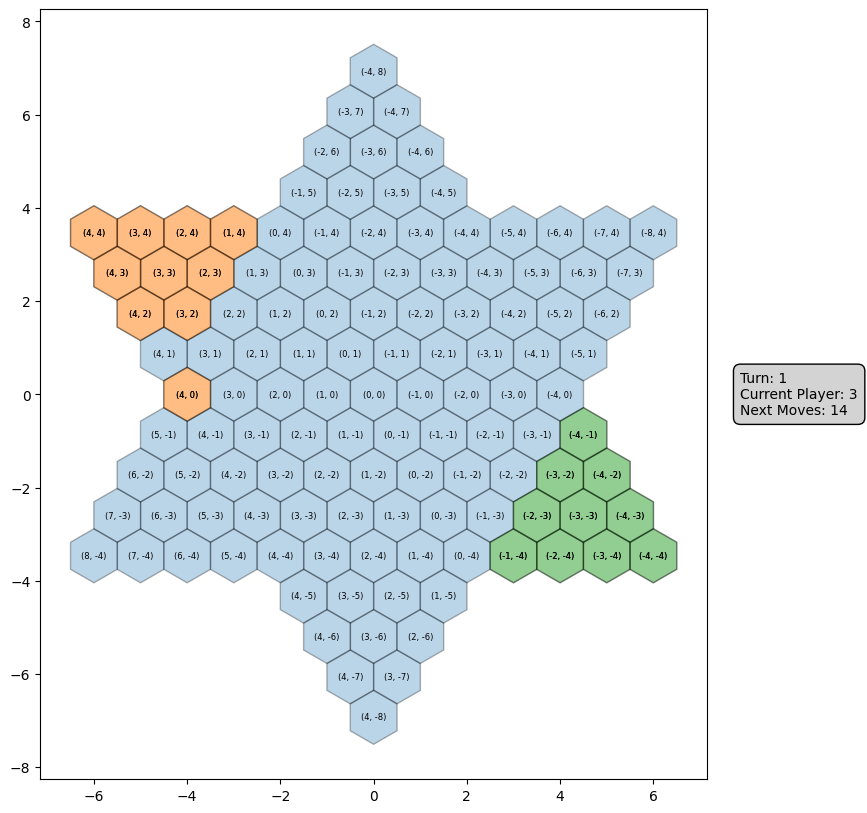

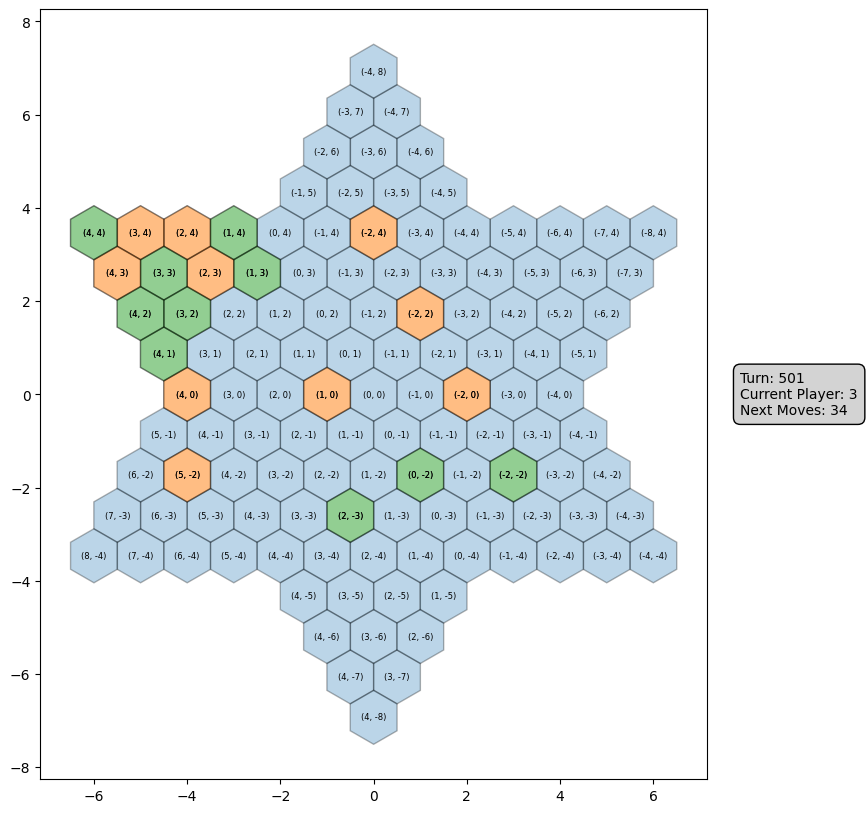

In [16]:
# model_1 = BootstrapModel()
model_1 = DqlCnnModel(
    model_path=model_save_path,                          
    board_size=4                               
)

# model_2 = DqlCnnModel(
#     model_path=model_save_path,                          
#     board_size=4                               
# )
model_2 = BootstrapModel()


# Simulate the game using the models
game_simulation = GameSimulation.simulate_game(
    models=[model_1, model_2],  # DQL model plays against the bootstrap model
    name=f"dql_cnn_vs_bootstrap_{model_version}_simulation",
    version="v1.0.0",
    print_period=500,
    show_coordinates=True,
    max_turns=1000
)


Creating Animation:   0%|          | 0/1001 [00:00<?, ?it/s]


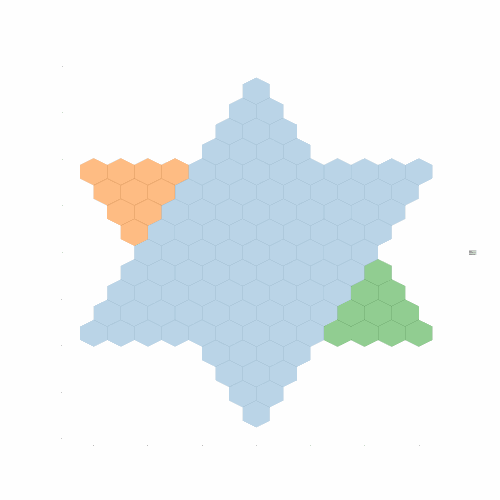

In [18]:
game_simulation.display(sample_period=1)
# game_simulation.save_animation()

In [ ]:
game_sequence = game_simulation._to_game_sequence()
for i, (move, game) in enumerate(zip(game_simulation.data.historical_moves, game_sequence)):
    print(f"\nCurrent Player: {game.get_current_player().player_id} \n{move}\nTurn: {i}")
    game.print()
    if i > 20:
        break